# YOLO Model Inference on AMD RyzenAI

This notebook demonstrates how to perform object detection using the YOLO-V8 model on a RyzenAI device with the Optimum-AMD.

## About RyzenAI

* AMD's Ryzen™ AI family of laptop processors provide users with an integrated Neural Processing Unit (NPU). 
* This frees up the main CPU and GPU, resulting in improved performance for AI-related tasks.
* All of this is made possible based on Ryzen™ AI technology built on AMD XDNA™ architecture, purpose-built to run AI workloads efficiently and locally, offering a host of benefits for the developer innovating the next groundbreaking AI app.

## Prerequisites

Ensure you have the following setup:
- A laptop with an AMD Ryzen processor.
- The RyzenAI environment is properly configured according to the [Installation](https://ryzenai.docs.amd.com/en/latest/inst.html) and [Runtime Setup](https://ryzenai.docs.amd.com/en/latest/runtime_setup.html) guides.
    - Install NPU Driver
    - Install RyzenAI Software

In [1]:
# !git clone https://github.com/huggingface/optimum-amd.git
# !cd optimum-amd && pip install -e .[ryzenai]

In [2]:
import platform
import sys
import cpuinfo
from pprint import pprint

print("Python version:", sys.version)
print("Platform:", platform.platform())
print("Processor Architecture:", platform.architecture())
print("Machine:", platform.machine())
print("System:", platform.system())
cpu_info = cpuinfo.get_cpu_info()
print("Processor:", cpu_info["brand_raw"])

Python version: 3.9.18 (main, Sep 11 2023, 14:09:26) [MSC v.1916 64 bit (AMD64)]
Platform: Windows-10-10.0.22631-SP0
Processor Architecture: ('64bit', 'WindowsPE')
Machine: AMD64
System: Windows
Processor: AMD Ryzen 9 7940HS w/ Radeon 780M Graphics


## Preparing Yolo Model for Inference

1. Pretrained Model
2. Quantize model using the RyzenAI quantization tools [Model Quantization guide](https://huggingface.co./docs/optimum/main/en/amd/ryzenai/usage_guides/quantization).
3. Export to ONNX

### [Alternative] Using Yolo from RyzenAI Pre-Optimized Model Zoo
[RyzenAI Pre-Optimized Model Zoo](https://huggingface.co./models?other=RyzenAI), is a collection of 
pre-quantized models across various tasks such-as image-classification, object-detection, image-segmentation etc.

In [3]:
model_id = "amd/yolov8m"

# Inference using Hugging Face Pipelines

The [pipelines](https://huggingface.co./docs/transformers/en/main_classes/pipelines) are a great and easy way to use models for inference. These pipelines are objects that abstract most of the complex code from the library, offering a simple API dedicated to several tasks.

In [4]:
# from transformers import pipeline
from optimum.amd.ryzenai import pipeline
from optimum.amd.ryzenai.utils import plot_bbox

detector = pipeline("object-detection", model=model_id, model_type="yolov8")

No Ryzen AI configuration file was provided. Using default: C:\Users\Mohit\Work\optimum-amd-hf\optimum\amd\ryzenai\configs\vaip_config.json.

W0606 21:30:17.961694 14520 warnings.py:109] C:\Users\Mohit\anaconda3\envs\ryzensw1.1-hcast\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(



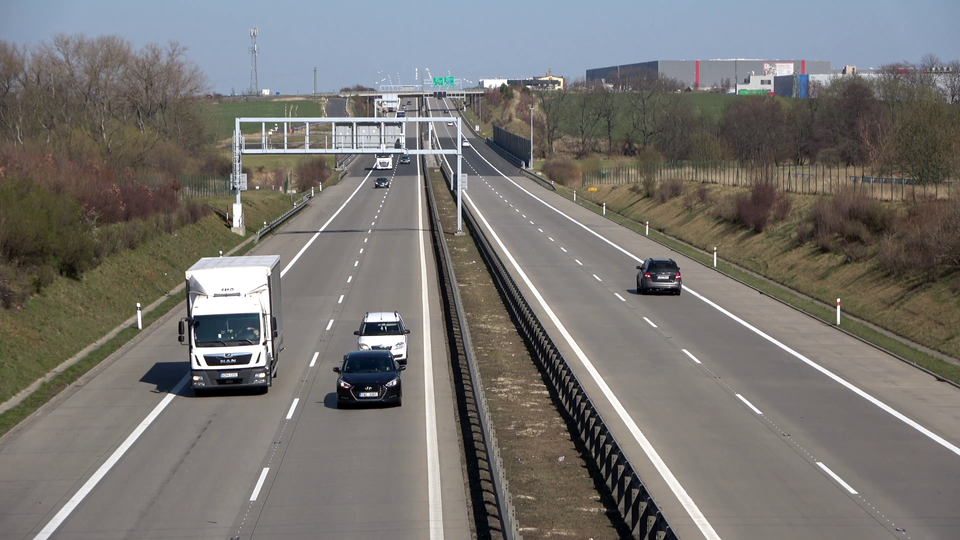

In [5]:
import requests
from PIL import Image

# Load an image
image = Image.open("vehicles.png")
image

Image with bounding boxes saved to plot_bbox_output.png


[{'box': {'xmax': 284, 'xmin': 177, 'ymax': 395, 'ymin': 255},
  'label': 7.0,
  'score': 0.9324532747268677},
 {'box': {'xmax': 683, 'xmin': 635, 'ymax': 295, 'ymin': 257},
  'label': 2.0,
  'score': 0.8670357465744019},
 {'box': {'xmax': 404, 'xmin': 333, 'ymax': 407, 'ymin': 349},
  'label': 2.0,
  'score': 0.8670357465744019},
 {'box': {'xmax': 411, 'xmin': 353, 'ymax': 367, 'ymin': 311},
  'label': 2.0,
  'score': 0.6513549089431763},
 {'box': {'xmax': 392, 'xmin': 374, 'ymax': 189, 'ymin': 175},
  'label': 2.0,
  'score': 0.622459352016449}]


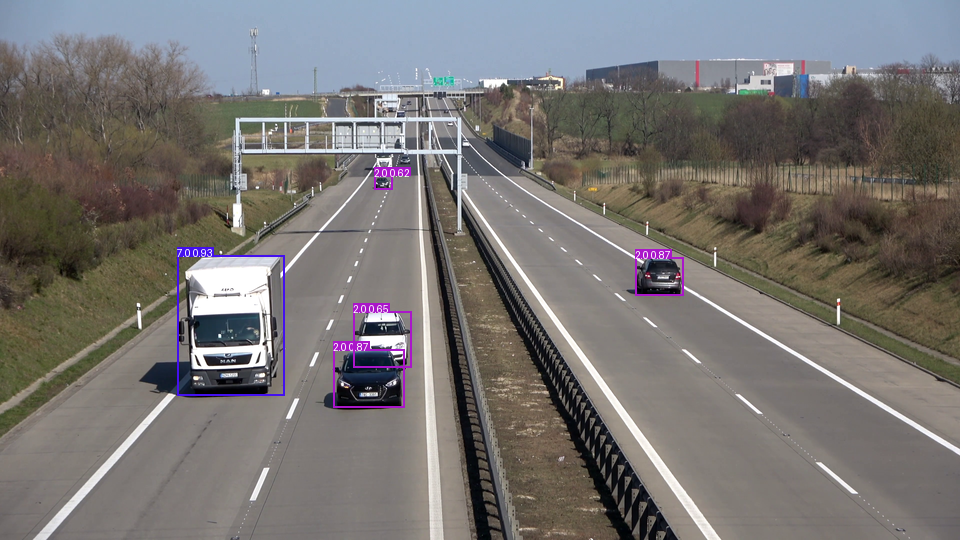

In [6]:
outputs = detector(image)

pprint(outputs)
plot_bbox(image.copy(), outputs)

## Comparation with CPU

W0606 21:30:22.157617 14520 warnings.py:109] C:\Users\Mohit\anaconda3\envs\ryzensw1.1-hcast\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(



CPU Average latency (ms) - 234.66 +\- 0.35
Ryzen Average latency (ms) - 97.75 +\- 0.35


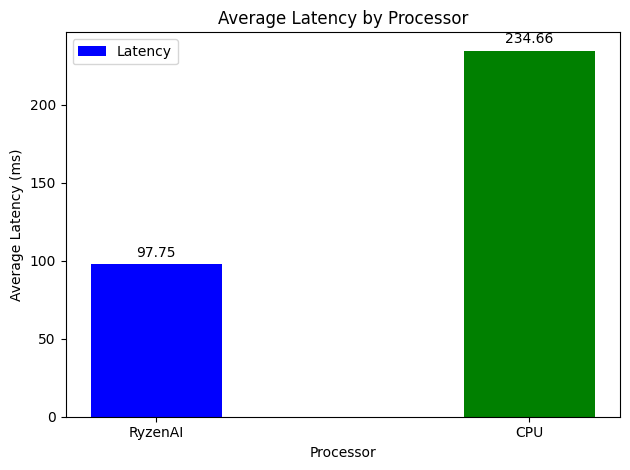

In [7]:
from optimum.amd.ryzenai import RyzenAIModelForObjectDetection
from utils import measure_latency, plot_latency

model_cpu = RyzenAIModelForObjectDetection.from_pretrained(model_id, provider="CPUExecutionProvider")
cpu_latency, time_std_ms  = measure_latency(model_cpu, image)

model_ryzen = detector.model
ryzen_latency, time_std_ms  = measure_latency(model_ryzen, image)

print(f"CPU Average latency (ms) - {cpu_latency:.2f} +\- {time_std_ms:.2f}")
print(f"Ryzen Average latency (ms) - {ryzen_latency:.2f} +\- {time_std_ms:.2f}")

plot_latency(cpu_latency, ryzen_latency)












# Demo 2

# [Preview] Local LLM Inference on AMD RyzenAI 

Please note this is a preview and work in progress. We're actively working on enhancing the performance. In a couple of weeks, we expect to have a more polished and efficient version ready.

In [2]:
model_id = "facebook/opt-125m"

## Quantization using Brevitas

Brevitas allows to quantize directly PyTorch models, which can later be exported to ONNX.

For more info: https://huggingface.co./docs/optimum/main/en/amd/brevitas/usage_guide

In [3]:
from pprint import pprint

from optimum.amd import BrevitasQuantizationConfig, BrevitasQuantizer
from optimum.amd.brevitas.export import onnx_export_from_quantized_model

quantizer = BrevitasQuantizer.from_pretrained(model_id)

C:\Users\Mohit\anaconda3\envs\ryzensw1.1-hcast\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [4]:
qconfig = BrevitasQuantizationConfig(activations_equalization=None)

In [5]:
quantized_model = quantizer.quantize(qconfig)

## Export

In [6]:
save_path = "brevitas_opt_onnx"
onnx_export_from_quantized_model(quantized_model, save_path)

Using the export variant default. Available variants are:
    - default: The default ONNX variant.
C:\Users\Mohit\anaconda3\envs\ryzensw1.1-hcast\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

***** Exporting submodel 1/1: OPTForCausalLM *****
Using framework PyTorch: 2.2.1+cpu
Overriding 1 configuration item(s)
	- use_cache -> True
C:\Users\Mohit\anaconda3\envs\ryzensw1.1-hcast\lib\site-packages\transformers\models\opt\modeling_opt.py:826: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  elif attention_mask.shape[1] != mask_seq_length:
C:\Users\Mohit\anaconda

In [7]:
%ls $save_path

 Volume in drive C is OS
 Volume Serial Number is 22E8-6B24

 Directory of C:\Users\Mohit\Work\optimum-amd-hf\demo\brevitas_opt_onnx

06-06-2024  21:31    <DIR>          .
06-06-2024  21:31    <DIR>          ..
06-06-2024  21:31               749 config.json
06-06-2024  21:31               139 generation_config.json
06-06-2024  21:31           456,318 merges.txt
06-06-2024  21:31       285,164,226 model.onnx
06-06-2024  21:31               578 special_tokens_map.json
06-06-2024  21:31         2,108,658 tokenizer.json
06-06-2024  21:31               699 tokenizer_config.json
06-06-2024  21:31           798,293 vocab.json
               8 File(s)    288,529,660 bytes
               2 Dir(s)  205,649,305,600 bytes free


In [8]:
import os
os.environ["XLNX_USE_SHARED_CONTEXT"] = "1"

## Inference

In [9]:
from optimum.amd.ryzenai import RyzenAIModelForCausalLM, pipeline
from transformers import AutoTokenizer

In [10]:
model = RyzenAIModelForCausalLM.from_pretrained(save_path)
tokenizer = AutoTokenizer.from_pretrained(save_path)

pipe = pipeline("text-generation", model=model, max_length=30, tokenizer=tokenizer)

RYZENAI_SW_PATH environment variable is not set. Attempting to clone RyzenAI-SW repository now...

Builtins: impl=v0, quant_mode=w8a8
No Ryzen AI configuration file was provided. Using default: C:\Users\Mohit\Work\optimum-amd-hf\optimum\amd\ryzenai\configs\vaip_config_transformers.json.



In [11]:
prompt = "Hey, are you conscious? Can you talk to me?"
pprint(pipe(prompt))

[{'generated_text': 'Hey, are you conscious? Can you talk to me?\n'
                    "I'm not conscious. I'm just a little bit scared. I'm not "
                    'sure'}]
